In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
from skpsl import ProbabilisticScoringList
from scipy.stats import kendalltau
from scipy.linalg import norm
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

dburl = ""

In [2]:
#Alter Studienbeginn>23.5000,Männlich,Migrant,Note Abschlusszeugnis>1.3500,Gymnasium besucht,Mathe Leistungskurs,Berufsbegleitendes Studium,Fernstudium,Zufriedenheit Leben>5.5000,Gewissenhaftigkeit>3.1250,Verträglichkeit>3.3750,Extraversion>3.3750,Offenheit Intellekt>3.3000,Neurotizismus>3.8750
features = ["age","male","migr", "grade", "isgym", "mathlk", "dual", "fern", "zufr", "gewiss", "vertr", "extrav", "offen", "neuro"]
features = dict(enumerate(features))
features

{0: 'age',
 1: 'male',
 2: 'migr',
 3: 'grade',
 4: 'isgym',
 5: 'mathlk',
 6: 'dual',
 7: 'fern',
 8: 'zufr',
 9: 'gewiss',
 10: 'vertr',
 11: 'extrav',
 12: 'offen',
 13: 'neuro'}

In [3]:
app_logentry = pd.read_sql_table("app_logentry", dburl)
app_pslparam = pd.read_sql_table("app_pslparam", dburl)
app_subject = pd.read_sql_table("app_subject", dburl)
app_dataset = pd.read_sql_table("app_dataset", dburl)
app_experiment = pd.read_sql_table("app_experiment", dburl)

In [4]:
# expert psls
df = pd.read_csv("experiment/all_apps_wide-2024-09-16.csv")
df = df[df["participant._current_app_name"].notna()]

In [5]:
app_dataexperimentsubj = app_dataset.merge(app_experiment, left_on="name", right_on="dataset_id").merge(app_subject, left_on="id", right_on="experiment_id", suffixes=("_experiment", "_subj") )
df_params = app_dataexperimentsubj[app_dataexperimentsubj['id_subj'].isin(df['study_students.1.player.pslvis_subject_id'])]
df_subj_ds = df_params[["id_subj", "dataset_id"]]
df_subj_ds = dict(df_subj_ds.values)
df_subj_ds

{'8NEtzA': 'schüler-ing-bin',
 'LN3JTA': 'schüler-ing-bin',
 'AX6jaw': 'schüler-ing-bin',
 'ZligBg': 'schüler-ing-bin',
 'Dlh1Ug': 'schüler-wiwi-bin',
 '7P-hCA': 'schüler-mathe-bin',
 'GGPALw': 'schüler-*-bin'}

In [6]:
def fit_psl(dataset, features=None, scores=None, k="predef", drop_math_col=False):
    match dataset:
        case "schüler-ing-bin":
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_train_ONLY_Ingenieur Studium_binary.csv")
        case "schüler-wiwi-bin":
            # this experiment "Dlh1Ug" has actually been done with the non-binary dataset, but was later relabeled
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_train_ONLY_Rechts Wirtschafts Sozial Studium.csv")
        case "schüler-mathe-bin":
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_train_ONLY_Mathe Natur Studium_binary.csv")
        case "schüler-*-bin":
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_train_binary.csv")
            if drop_math_col:
                data.drop(columns="Mathe Natur Studium",inplace=True)
        case _:
            raise ValueError()
    X = data.iloc[:, 1:]
    y = data.iloc[:, 0]

    psl = ProbabilisticScoringList({-3, -2, -1, 0, 1, 2, 3})
    if features is None:
        return psl.fit(X,y)
    scores = [scores[f_] for f_ in features]
   
    return psl.fit(X, y, predef_features=features, predef_scores=scores, k=k)

## Create a PSL from the feature assessments
- for each expert we have
- a list of values between -100 and 100 for each feature.
- this assessments can be converted into a ranking of features with ties
- this the ties need to be broken arbitrarily and this will create a psls feature ordering
- hence each feature assessment per expert yields a expert psl

- then we create the data driven psl

- also we need to calculate all psls that an expert creates during co-construction (with timestamps)

- finally we need to create a distance metric between psls

### analysis
this allows to observe how the experts move in the space of psls
- relative to each other
- how the fraction of the distance to the expert psl and the data driven psl develops over the course of co-construction.

In [7]:
key = 'study_students.1.player.mental_feature_'
df_feature_ = df.filter(regex=f"{key.replace('.', r'\.')}.+|study_students\\.1\\.player\\.pslvis_subject_id")
df_feature_.columns = df_feature_.columns.str.replace(key, '', regex=False)
df_feature_.columns = ["subject_id"] + list(df_feature_.columns[1:])
# drop "studium mathe"
#df_feature_.drop(columns="MatheNaturStudium", inplace=True)
featurenames=list(df_feature_.columns[2:])

# feature order aligns with "features"
df_feature_

,subject_id,MatheNaturStudium,AlterStudienbeginn,Männlich,Migrant,NoteAbschlusszeugnis,Gymnasiumbesucht,MatheLeistungskurs,BerufsbegleitendesStudium,Fernstudium,ZufriedenheitLeben,Gewissenhaftigkeit,Verträglichkeit,Extraversion,OffenheitIntellekt,Neurotizismus
0,ZligBg,0,-20,0,-50,-40,0,30,90,-70,30,70,80,50,40,-90
1,8NEtzA,0,30,-30,0,0,-30,50,40,0,67,10,0,33,50,-66
2,LN3JTA,0,40,-20,0,50,30,30,-30,-40,40,0,0,10,10,-30
3,Dlh1Ug,0,0,-29,-15,80,36,10,-20,0,40,60,30,30,60,-74
4,AX6jaw,0,29,0,-82,51,58,0,0,-55,100,69,44,65,62,-68
5,GGPALw,0,34,0,-60,0,55,0,20,-51,81,55,48,32,70,-80
6,7P-hCA,0,50,-20,-30,40,50,20,-30,-45,70,70,10,20,26,-21


In [8]:
df_feature=df_feature_.drop(columns=["MatheNaturStudium","subject_id"])
sorted_columns = df_feature.mean().abs().sort_values(ascending=False)
df_feature = df_feature[sorted_columns.index]
df_feature=df_feature.melt(var_name="feature", value_name="value")
df_feature.insert(0,"Phase", "Mental Modal")

data = []
for i, row in df_feature_.iterrows():
    psl = fit_psl(df_subj_ds[row["subject_id"]], drop_math_col=True)
    data.append({featurenames[f]:s*100/3 for f,s in zip(psl.features, psl.scores)})
d_ = pd.DataFrame(data).melt(var_name="feature", value_name="value")
d_.insert(0,"Phase", "Reference")
df_feature = pd.concat([df_feature, d_])

/tmp/ipykernel_169138/3614864809.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_feature["feature"].replace(dict(Neurotizismus="Neuroticism",
/tmp/ipykernel_169138/3614864809.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, va="top", ha="right")


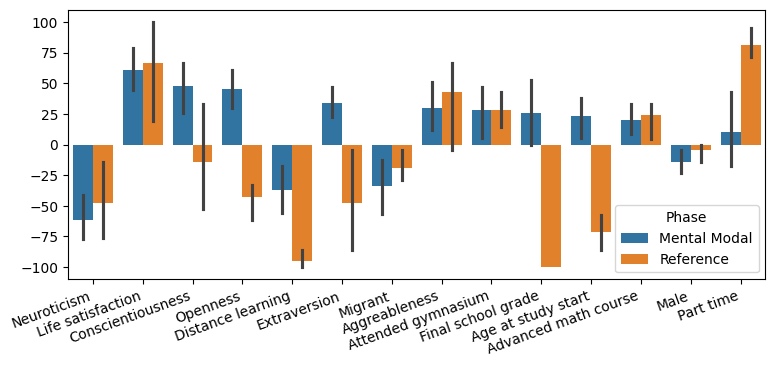

In [9]:
plt.figure(figsize=(9,3.5))
df_feature["feature"].replace(dict(Neurotizismus="Neuroticism",
                                   ZufriedenheitLeben="Life satisfaction",
                                   Gewissenhaftigkeit="Conscientiousness",
                                   OffenheitIntellekt="Openness",
                                   Fernstudium="Distance learning",
                                   Extraversion="Extraversion",
                                   Migrant="Migrant",
                                   Verträglichkeit="Aggreableness",
                                   Gymnasiumbesucht="Attended gymnasium",
                                   NoteAbschlusszeugnis="Final school grade",
                                   AlterStudienbeginn="Age at study start",
                                   MatheLeistungskurs="Advanced math course",
                                   Männlich="Male",
                                   BerufsbegleitendesStudium="Part time"
                                   ), inplace=True)
ax = sns.barplot(df_feature, x="feature", y="value", hue="Phase")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, va="top", ha="right")
#ax.set_xticklabels(["Neuroticism", "Life satisfaction", "Openness", "Conscientiousness", "Extraversion", "Distance learning", "Agreeableness", "Migrant", "Final grade", "Advanced math course", "Attended high school", "Part-time studies", "Age at study start", "Male"], rotation=90, va="top", ha="right")
plt.xlabel(None)  # remove the axis label
plt.ylabel(None)  # remove the axis label
plt.savefig("featureassesment.pdf", bbox_inches="tight")

In [10]:
models = dict()

for i, row in df_feature_.iterrows():
    id_ = row["subject_id"]
    if id_ != "GGPALw":
        row.drop(labels="MatheNaturStudium", inplace=True)

    #print(row[0])
    v = row[1:].values.astype(float)
    #print(v)
    #print(list(enumerate(v)))
    # first value is feature with highest absolute assesment
    f_perm = np.abs(v).argsort()[::-1]
    #print(f_perm)
    v = v[f_perm]
    scores = (v/100*3).round()
    #print(scores)
    models[id_] = {-1:list(zip(f_perm,scores))}

for id in models:
    print(id)
    entries = app_logentry[app_logentry.subject_id == id][["created_at", "data"]]
    entries = entries.sort_values("created_at")

    if id == "AX6jaw":
        # remove all data before first reset
        idx = entries.index.get_loc(next(i for i, v  in entries.iterrows() if v.data["path"].endswith("reset")))
        entries = entries.iloc[idx+1:]
        

    # list of feature,score tuples
    features = []
    scores = dict()
    for _, entry in entries.iterrows():
        data = entry.data
        payload = entry.data["values"]
        #print("data", data)
        stem = Path(data["path"]).stem
        try:
            match stem:
                case "update-table":
                    match payload.get("type"):
                        case "feature":
                            feature_index = int(payload.get("feature"))
                            fromlist = payload.get("fromList")
                            tolist = payload.get("toList")

                            if fromlist == "used" and tolist == "unused":
                                features.remove(feature_index)
                                del scores[feature_index]
                            elif fromlist == "unused" and tolist == "used":
                                to_ = payload.get("to", None)
                                to_ = None if to_ is None else int(to_) - 1
                                features.insert(len(features) if to_ is None else to_, feature_index)
                                scores[feature_index] = 1
                            elif fromlist == tolist == "used":
                                from_ = int(payload.get("from")) - 1
                                to_ = int(payload.get("to")) - 1
                                
                                f = features.pop(from_)
                                features.insert(to_, f)
                        case "score":
                            feature_index = int(payload.get("feature"))
                            diff = int(payload.get("diff"))
                            if diff:
                                scores[feature_index] = scores[feature_index] + diff

                case "reset":
                    features = []
                    scores = dict()
                case "add":
                    psl = fit_psl(df_subj_ds[id], features, scores, k=len(features) + 1)
                    if len(features) < len(psl.features):
                        # only add a feature if we have not yet added all features
                        features.insert(len(features), psl.features[-1])
                        scores[psl.features[-1]] = int(psl.scores[-1])
                case _:
                    if stem == "get":
                        continue
                    if data["path"].endswith("/"):
                        continue
                    print(data)
        except Exception as e:
            print(data)
            print("ERROR")
            print(e)
            print(features,scores)
            continue
        timestamp = entry.created_at.timestamp()
        #print(features,scores)
        models[id][timestamp] = [(f,scores[f]) for f in features]
    psl = fit_psl(df_subj_ds[id])
    models[id][float("inf")] = list(zip(psl.features, psl.scores))

ZligBg
8NEtzA
LN3JTA
Dlh1Ug
AX6jaw
GGPALw
7P-hCA


In [11]:
scoreset = {-3,-2,-1,1,2,3}
n_scores = len(scoreset)
def d_model(a, b, score_w=1):
    objs = max(len(a),len(b))+1
    fa_o,sa_o = list(zip(*a))
    fa_r = np.array([fa_o.index(item) + 1 if item in fa_o else objs for item in range(objs)])
    sa_r = np.full_like(fa_r, np.nan, dtype=float)
    sa_r[np.array(fa_o)] = sa_o

    fb_o,sb_o = list(zip(*b))
    fb_r = np.array([fb_o.index(item) + 1 if item in fb_o else objs for item in range(objs)])
    sb_r = np.full_like(fb_r, np.nan, dtype=float)
    sb_r[np.array(fb_o)] = sb_o

    sr = sa_r-sb_r
    sr = sr[~np.isnan(sr)]/n_scores

    try:
        return (1-kendalltau(fb_r,fa_r)[0])/2 + score_w * norm(sr)
    except:
        return np.nan

ZligBg
[(13, -3.0), (6, 3.0), (10, 2.0), (9, 2.0), (7, -2.0), (11, 2.0), (2, -2.0), (12, 1.0), (3, -1.0), (8, 1.0), (5, 1.0), (0, -1.0), (4, 0.0), (1, 0.0)]
(1724839844.689567, [(13, 1)])
(1724840540.019431, [(2, 1), (6, 2), (9, 1), (11, 2), (13, -2)])
[(3, -3), (10, 2), (11, -3), (4, 1), (13, -2), (7, -3), (9, -2), (0, -2), (2, -1), (8, 3), (6, 2), (5, 1), (12, -1), (1, 0)]
8NEtzA
[(8, 2.0), (13, -2.0), (12, 2.0), (5, 2.0), (6, 1.0), (11, 1.0), (4, -1.0), (1, -1.0), (0, 1.0), (9, 0.0), (10, 0.0), (7, 0.0), (3, 0.0), (2, 0.0)]
(1725261090.977661, [(3, 1)])
(1725261350.361887, [(3, -3), (10, 2), (11, -3), (4, 1), (13, -2)])
[(3, -3), (10, 2), (11, -3), (4, 1), (13, -2), (7, -3), (9, -2), (0, -2), (2, -1), (8, 3), (6, 2), (5, 1), (12, -1), (1, 0)]
LN3JTA
[(3, 2.0), (8, 1.0), (7, -1.0), (0, 1.0), (13, -1.0), (6, -1.0), (5, 1.0), (4, 1.0), (1, -1.0), (12, 0.0), (11, 0.0), (10, 0.0), (9, 0.0), (2, 0.0)]
(1725280681.179432, [(0, 1)])
(1725281047.853545, [(3, -3), (10, 2), (11, -3), (4, 1), (

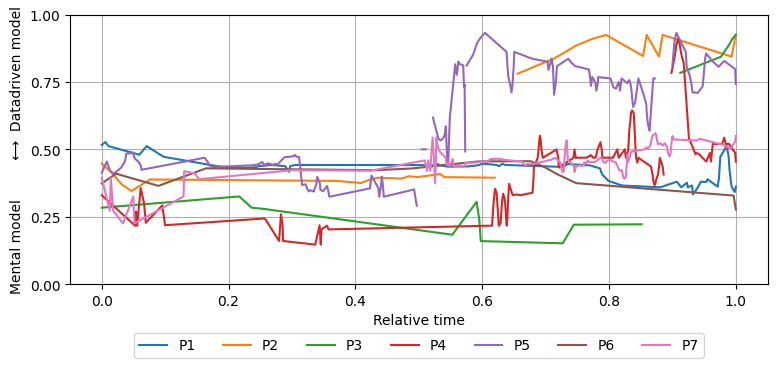

In [12]:
plt.figure(figsize=(9,3.5))
for id, ms in models.items():
    print(id)
    all_models = list(ms.items())
    start = all_models[0][1]
    end = all_models[-1][1]
    core = all_models[1:-1]
    print(start)
    print(core[0])
    print(core[-1])
    print(end)
    d = []
    for t, m in core:
        if not m:
            d.append(np.nan)
            continue
        d0 = d_model(start,m, score_w=1)
        d1 = d_model(m,end, score_w=1)
        d.append((d0/(d0+d1)))
        #print(m,d0,d1,d0/(d0+d1))
    times = np.array([t for t, _ in core])
    times = (times - np.min(times))/np.ptp(times)
    plt.plot(times,d, label = id)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_xlabel("Relative time")
ax.set_ylabel("Mental model         ⟷  Datadriven model")
plt.legend(["P1","P2","P3","P4","P5","P6","P7"],    bbox_to_anchor=(0.5, -0.3),
    loc='lower center', ncols=7)
plt.ylim(0,1)
plt.grid(visible=True)
plt.savefig("navmodelspace.pdf", bbox_inches="tight")
